In [1]:
import numpy as np
import networkx as nx
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from scipy.optimize import minimize
from itertools import product
import matplotlib.pyplot as plt
import random

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeBrisbane, FakeCusco
import os

In [2]:
def create_movrp_qubo_matrices(num_customers, num_vehicles, costs_eff, costs_ser):
    num_vars = num_customers * num_vehicles
    Q_eff = np.zeros((num_vars, num_vars))
    Q_ser = np.zeros((num_vars, num_vars))
    
    penalty_factor = 50
    
    for i in range(num_customers):
        for j in range(num_vehicles):
            var_idx = i * num_vehicles + j
            Q_eff[var_idx, var_idx] = costs_eff[i]
            Q_ser[var_idx, var_idx] = costs_ser[i]
            
    for i in range(num_customers):
        for j1 in range(num_vehicles):
            idx1 = i * num_vehicles + j1
            Q_eff[idx1, idx1] += -penalty_factor
            Q_ser[idx1, idx1] += -penalty_factor
            
            for j2 in range(j1 + 1, num_vehicles):
                idx2 = i * num_vehicles + j2
                Q_eff[idx1, idx2] += 2 * penalty_factor
                Q_ser[idx1, idx2] += 2 * penalty_factor

    return Q_eff, Q_ser


In [4]:
# 예제 파라미터
num_customers = 5
num_vehicles = 2
num_qubits = num_customers * num_vehicles
num_layers = 1

# 가상의 비용 데이터 (고객 방문 비용)
np.random.seed(42)
costs_eff = np.random.uniform(low=0.0, high=1.0, size=num_customers) * 10
noise = np.random.uniform(low=-1.0, high=1.0, size=num_customers) * 1
costs_ser = (np.max(costs_eff) + np.min(costs_eff)) - costs_eff + noise
costs_ser = np.maximum(costs_ser, 0)

def find_min_max_cost_bruteforce(q_matrix, num_vars):
    min_cost = np.inf
    max_cost = -np.inf
    # 모든 가능한 2진 비트스트링 생성
    for i in range(2**num_vars):
        bitstring = format(i, '0' + str(num_vars) + 'b')
        x = np.array([int(c) for c in bitstring])
        cost = np.dot(x, np.dot(q_matrix, x))
        if cost < min_cost:
            min_cost = cost
        if cost > max_cost:
            max_cost = cost
    return min_cost, max_cost

# QUBO 행렬 생성
Q_eff, Q_ser = create_movrp_qubo_matrices(num_customers, num_vehicles, costs_eff, costs_ser)
eff_min_cost, eff_max_cost = find_min_max_cost_bruteforce(Q_eff, num_qubits)
ser_min_cost, ser_max_cost = find_min_max_cost_bruteforce(Q_ser, num_qubits)


print(f"eff_min_cost: {eff_min_cost}")
print(f"eff_max_cost: {eff_max_cost}")
print(f"ser_min_cost: {ser_min_cost}")
print(f"ser_max_cost: {ser_max_cost}")
print("Efficiency QUBO Matrix (Q_eff):\n", Q_eff)
print("\nService Quality QUBO Matrix (Q_ser):\n", Q_ser)

eff_min_cost: -221.88074508291842
eff_max_cost: 56.238509834163146
ser_min_cost: -223.00372383882677
ser_max_cost: 53.99255232234649
Efficiency QUBO Matrix (Q_eff):
 [[-46.25459881 100.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.         -46.25459881   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.         -40.49285694 100.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.         -40.49285694   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         -42.68006058
  100.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
  -42.68006058   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0

In [5]:
def qubo_matrix_to_pauli_list(q_matrix: np.ndarray) -> list[tuple[str, float]]:
    """
    QUBO 행렬을 Ising 해밀토니안의 SparsePauliOp 리스트 형식으로 변환합니다.
    
    Args:
        q_matrix (np.ndarray): QUBO 행렬.

    Returns:
        list[tuple[str, float]]: (Pauli_string, coefficient) 튜플 리스트.
    """
    num_qubits = q_matrix.shape[0]
    pauli_list = []
    
    # Ising 변수(z)와 QUBO 변수(x)의 관계: x = (1 - z)/2를 이용해 변환합니다.
    # QUBO 목적 함수: sum_i Q_ii * x_i + sum_i<j Q_ij * x_i * x_j
    # Ising 해밀토니안: sum_i h_i * Z_i + sum_i<j J_ij * Z_i * Z_j + constant_term

    # 대각선 항 (Z 연산자)
    for i in range(num_qubits):
        # Q_ii * x_i -> Q_ii * (1-Z_i)/2
        paulis = ["I"] * num_qubits
        paulis[i] = "Z"
        # 큐비트 순서가 반대이므로 뒤집어야 함
        pauli_list.append(("".join(paulis)[::-1], -q_matrix[i, i] / 2))
        
    # 비대각선 항 (ZZ 연산자)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            if q_matrix[i, j] != 0:
                # Q_ij * x_i * x_j -> Q_ij * (1-Z_i)/2 * (1-Z_j)/2
                paulis = ["I"] * num_qubits
                paulis[i], paulis[j] = "Z", "Z"
                # 큐비트 순서가 반대이므로 뒤집어야 함
                pauli_list.append(("".join(paulis)[::-1], q_matrix[i, j] / 4))
                
    # 상수 항 처리
    const_term = 0
    for i in range(num_qubits):
        const_term += q_matrix[i, i] / 2
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            const_term += q_matrix[i, j] / 4
            
    pauli_list.append(("I" * num_qubits, const_term))

    return pauli_list


In [6]:
H_eff = SparsePauliOp.from_list(qubo_matrix_to_pauli_list(Q_eff))
H_ser = SparsePauliOp.from_list(qubo_matrix_to_pauli_list(Q_ser))
print("\nEfficiency Hamiltonian:\n", H_eff)
print("\nService Quality Hamiltonian:\n", H_ser)


Efficiency Hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIIIZZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIZZIIIIII', 'ZZIIIIIIII', 'IIIIIIIIII'],
              coeffs=[ 23.12729941+0.j,  23.12729941+0.j,  20.24642847+0.j,  20.24642847+0.j,
  21.34003029+0.j,  21.34003029+0.j,  22.00670758+0.j,  22.00670758+0.j,
  24.2199068 +0.j,  24.2199068 +0.j,  25.        +0.j,  25.        +0.j,
  25.        +0.j,  25.        +0.j,  25.        +0.j, -96.88074508+0.j])

Service Quality Hamiltonian:
 SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIIIZZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIZZIIIIII', 'ZZIIIIIIII', 'IIIIIIIIII'],
              coeffs=[ 21.68304134+0.j,  21.68304134+0.j,  24.66182319+0.j,  24.66182319+0.j,
  22.76012883+0.j,  22.76012883+0.j,  22.35851267+0.j, 

Parameters to be optimized: [Parameter(beta_eff_0), Parameter(gamma_eff_0), Parameter(beta_ser_0), Parameter(gamma_ser_0)]


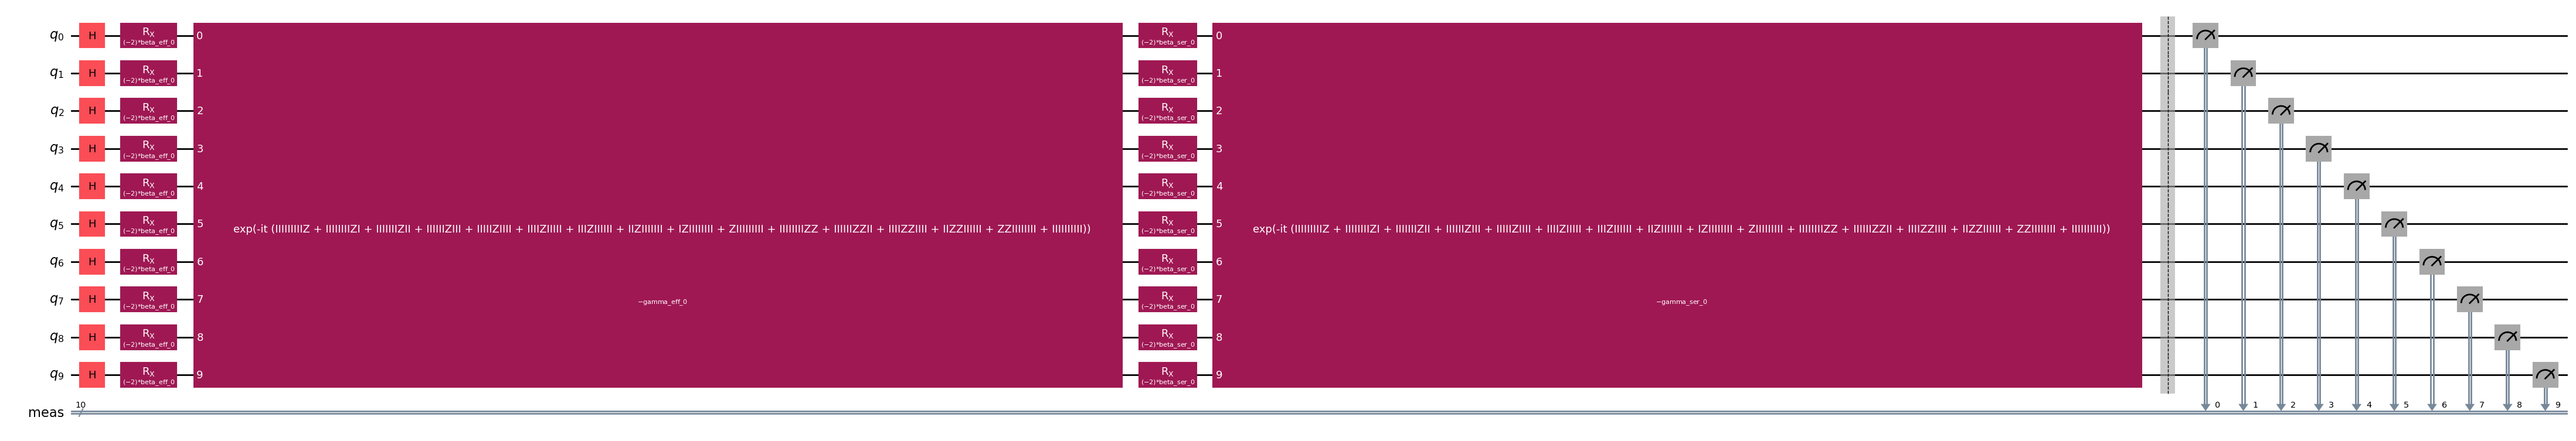

In [7]:
def create_qmoo_circuit(num_qubits, num_layers, H_eff, H_ser):
    """
    QMOO 회로를 생성합니다.
    
    Args:
        num_qubits (int): 큐비트 수 (QUBO 변수 수와 동일)
        num_layers (int): 회로 층 수
        H_eff (SparsePauliOp): 효율성 해밀토니안
        H_ser (SparsePauliOp): 서비스 품질 해밀토니안

    Returns:
        QuantumCircuit: 매개변수화된 QMOO 회로
        list: 최적화에 사용할 매개변수 리스트
    """
    qc = QuantumCircuit(num_qubits)
    
    # 파라미터 정의
    params = []
    for l in range(num_layers):
        params.append(Parameter(f'beta_eff_{l}'))
        params.append(Parameter(f'gamma_eff_{l}'))
        params.append(Parameter(f'beta_ser_{l}'))
        params.append(Parameter(f'gamma_ser_{l}'))

    # 초기 상태: 모든 중첩 상태
    qc.h(range(num_qubits))

    # QMOO 레이어 추가
    for l in range(num_layers):
        beta_eff, gamma_eff, beta_ser, gamma_ser = params[l*4:(l+1)*4]
        
        # 첫 번째 목적 (효율성)에 대한 페이즈 및 믹싱 연산자
        qc.rx(-2 * beta_eff, range(num_qubits)) # mixer op (RX 게이트는 e^(-i*theta*X/2) 연산)
        # PauliEvolutionGate를 사용하여 e^(-i*gamma*H) 연산 구현
        qc.append(PauliEvolutionGate(H_eff, time=-gamma_eff), qc.qubits)
        
        # 두 번째 목적 (서비스 품질)에 대한 페이즈 및 믹싱 연산자
        qc.rx(-2 * beta_ser, range(num_qubits)) # mixer op
        qc.append(PauliEvolutionGate(H_ser, time=-gamma_ser), qc.qubits)
    
    qc.measure_all()
    return qc, params

# 회로 생성
qmoo_circuit, qmoo_params = create_qmoo_circuit(num_qubits, num_layers, H_eff, H_ser)

print("Parameters to be optimized:", qmoo_params)
qmoo_circuit.draw('mpl', fold=-1)

In [8]:
IBM_YONSEI = os.getenv('IBM_YONSEI')

service = QiskitRuntimeService()

backend = service.backend('ibm_yonsei')
estimator = Estimator(backend)
sampler = Sampler(backend)

#backend_sim = FakeBrisbane()  # 또는 FakeManilaV2(), FakeCusco() 등
#backend_sim = AerSimulator.from_backend(backend)
backend_sim = AerSimulator()
estimator_sim = Estimator(backend_sim)
sampler_sim = Sampler(backend_sim)

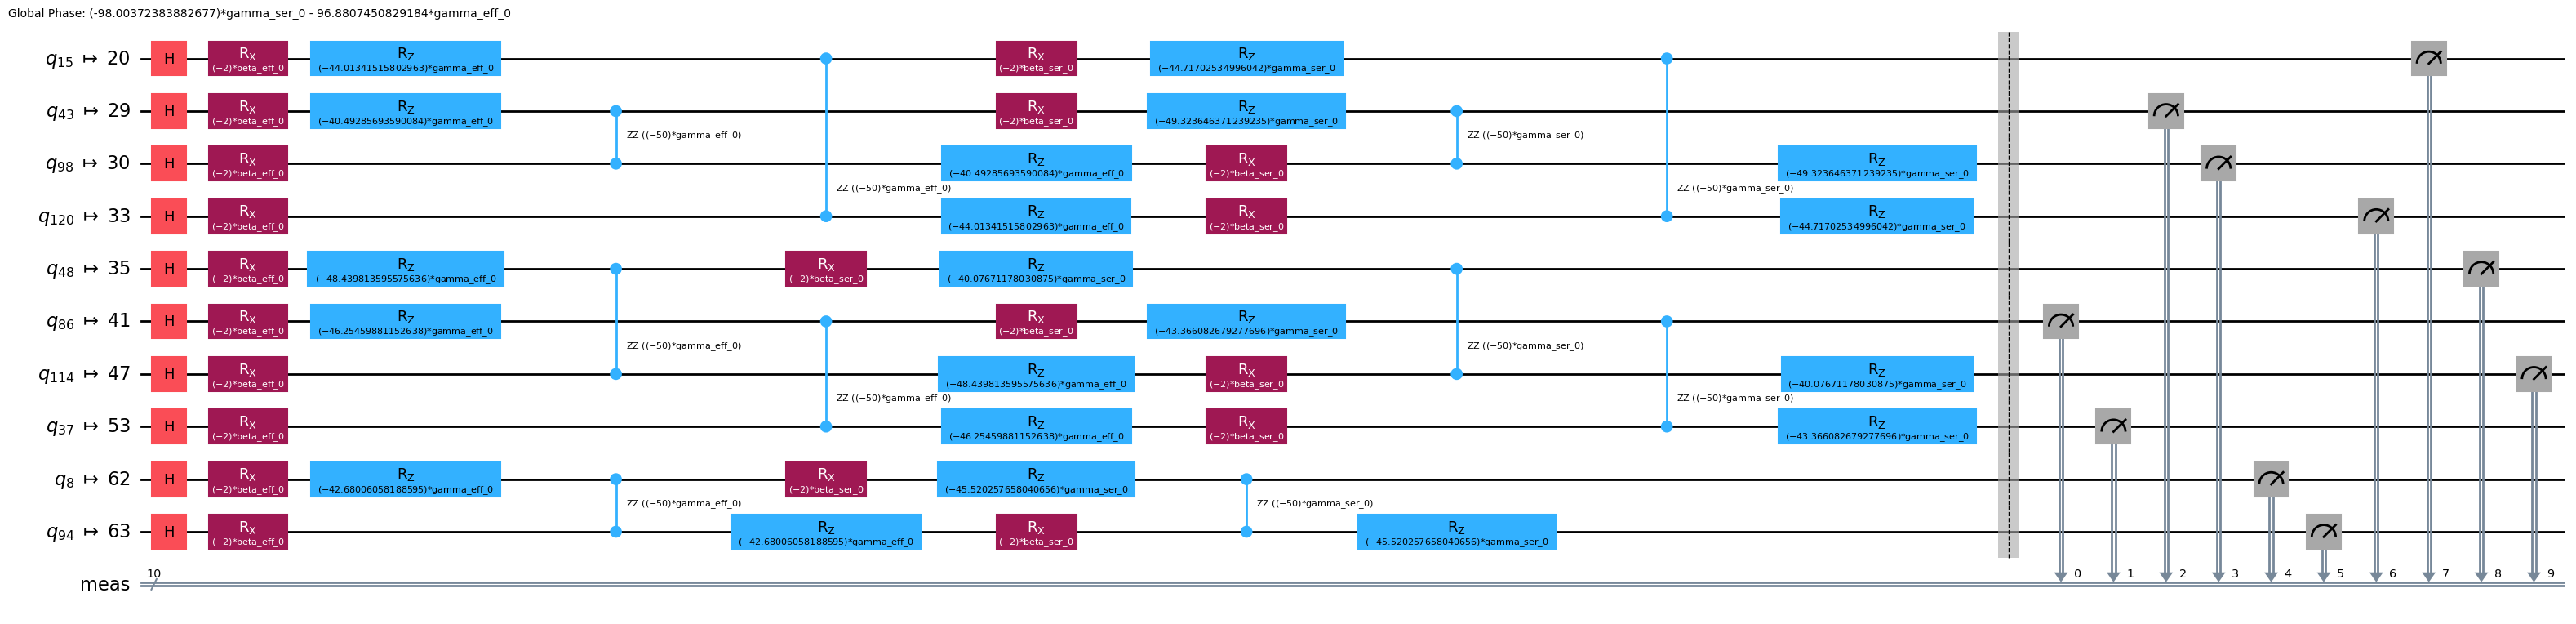

In [9]:
from qiskit_ibm_transpiler import generate_ai_pass_manager

coupling_map = backend.coupling_map

ai_transpiler_pass_manager = generate_ai_pass_manager(
    coupling_map=coupling_map,
    ai_optimization_level=3,
    optimization_level=3,
    ai_layout_mode="optimize",
)

qmoo_circuit_transpiled = ai_transpiler_pass_manager.run(qmoo_circuit)

#target = backend_sim.target
#pm = generate_preset_pass_manager(target=target, optimization_level=1)
#qmoo_circuit_transpiled = pm.run(qmoo_circuit)

# 트랜스파일된 회로에 맞게 해밀토니안도 레이아웃을 적용합니다.
h_eff_transpiled = H_eff.apply_layout(qmoo_circuit_transpiled.layout)
h_ser_transpiled = H_ser.apply_layout(qmoo_circuit_transpiled.layout)
qmoo_circuit_transpiled.draw('mpl', fold=-1)

In [10]:
def calculate_hypervolume(solutions, ref_point):
    hv = 0
    pareto_front = []
    for s1 in solutions:
        is_dominated = False
        for s2 in solutions:
            if s1[0] > s2[0] and s1[1] > s2[1]:
                is_dominated = True
                break
        if not is_dominated:
            pareto_front.append(s1)
            
    pareto_front.sort(key=lambda x: x[0])
    
    current_y = ref_point[1]
    for sol in pareto_front:
        hv += (sol[0] - ref_point[0]) * (current_y - sol[1])
        current_y = sol[1]
    
    return hv

In [13]:
def cost_func_sampler_hypervolume(params, circuit, qiskit_params, h_eff_transpiled, h_ser_transpiled, ref_point):
    
    # Sampler를 사용하기 때문에 session을 직접 생성합니다.
    sampler = sampler_sim
    # Sampler를 실행하여 측정 결과(counts)를 얻습니다.
    job = sampler.run([circuit.assign_parameters(dict(zip(qiskit_params, params)))], shots=1024)
    counts = job.result()[0].data.meas.get_counts()
    
    ns_solutions = sorted(counts.items(), key=lambda item: item[1], reverse=True)[:20]
    

    pubs_to_run = []
    
    # 측정 결과에서 비트스트링과 확률을 가져옵니다.
    for bitstring, _ in ns_solutions:
        state_circuit = QuantumCircuit(circuit.num_qubits)
        for i, bit in enumerate(bitstring):
            if bit == '1':
                state_circuit.x(i)
        
        # 각 상태 회로와 해밀토니안을 Estimator 작업 리스트에 추가합니다.
        pubs_to_run.append((state_circuit, h_eff_transpiled))
        pubs_to_run.append((state_circuit, h_ser_transpiled))
    
    # 모든 Estimator 작업을 한 번에 실행합니다.
    if pubs_to_run:
        result_estimator = estimator_sim.run(pubs_to_run).result()
        evs = [res.data.evs for res in result_estimator]
    else:
        return 0.0 # 측정된 해가 없을 경우 0 반환

    # 목적 함수 값 계산
    solution_vectors = []


    for i in range(0, len(evs), 2):
        eff_cost = evs[i]
        ser_cost = evs[i+1]

        normalized_eff = (eff_cost - eff_min_cost) / (eff_max_cost - eff_min_cost)
        normalized_ser = (ser_cost - ser_min_cost) / (ser_max_cost - ser_min_cost)
        solution_vectors.append((normalized_eff, normalized_ser))

    hv = calculate_hypervolume(solution_vectors, ref_point)
    # 하이퍼볼륨을 최소화 문제로 변환하여 반환
    return -hv

In [ ]:
# 참조점(Reference Point) 정의
# 최적화할 목적 함수들의 최악 값보다 더 나쁜 점을 설정해야 합니다.
ref_point = (1, 1)

# 초기 파라미터 생성
initial_params = np.random.rand(len(qmoo_params))

# COBYLA를 사용하여 하이퍼볼륨 최적화 수행
result_hypervolume = minimize(
    cost_func_sampler_hypervolume,
    initial_params,
    args=(qmoo_circuit_transpiled, qmoo_params, h_eff_transpiled, h_ser_transpiled, ref_point),
    method="COBYLA",
    options={"maxiter": 200, "rhobeg": 1, "catol": 1e-3, "tol": 0.0001},
)

# 최적화된 파라미터 추출
optimized_params = result_hypervolume.x

print("하이퍼볼륨 최적화 결과:")
print(f"성공 여부: {result_hypervolume.success}")
print(f"최적화된 파라미터: {optimized_params}")
print(f"최종 목적 함수 값 (-Hypervolume): {result_hypervolume.fun}")

In [ ]:
# 최적화된 매개변수로 회로를 최종 실행
sampler = sampler_sim
job = sampler.run([qmoo_circuit_transpiled.assign_parameters(dict(zip(qmoo_params, optimized_params)))], shots=10000)
final_counts = job.result()[0].data.meas.get_counts()

# 모든 해의 목적 함수 값 계산
final_solutions = []
for sol_bitstring, count in final_counts.items():
    state_idx = int(sol_bitstring, 2)
    eff_cost = (np.real(H_eff.to_matrix()[state_idx, state_idx]) - eff_min_cost)/(eff_max_cost - eff_min_cost)
    ser_cost = (np.real(H_ser.to_matrix()[state_idx, state_idx]) - ser_min_cost)/(ser_max_cost - ser_min_cost)
    final_solutions.append((eff_cost, ser_cost))


# 파레토 전선 추출
final_pareto_front = []
for s1 in final_solutions:
    is_dominated = False
    for s2 in final_solutions:
        if s1[0] > s2[0] and s1[1] > s2[1]:
            is_dominated = True
            break
    if not is_dominated:
        final_pareto_front.append(s1)

# 파레토 전선 시각화
plt.figure(figsize=(10, 8))
all_eff_costs = [s[0] for s in final_solutions]
all_ser_costs = [s[1] for s in final_solutions]
pareto_eff_costs = [s[0] for s in final_pareto_front]
pareto_ser_costs = [s[1] for s in final_pareto_front]

plt.scatter(all_eff_costs, all_ser_costs, c='gray', label='All Solutions')
plt.scatter(pareto_eff_costs, pareto_ser_costs, c='blue', label='Pareto Front')
plt.xlabel('Efficiency Cost (Total Distance)')
plt.ylabel('Service Quality Cost (Delivery Delay)')
plt.title('MOVRP Pareto Front (Hypervolume-based Optimization)')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Pareto-optimal solutions:")
for sol in sorted(final_pareto_front, key=lambda x: x[0]):
    print(f"Efficiency: {sol[0]:.2f}, Service Quality: {sol[1]:.2f}")

In [3]:
# 고객 위치와 차량 기지 위치 정의
np.random.seed(42)
customer_positions = {
    i: (np.random.rand() * 10, np.random.rand() * 10) for i in range(num_customers)
}
depot_position = (5, 5)

# 제공된 final_counts 데이터

# 가상의 QUBO 행렬 (실제로는 모델링 단계에서 생성)

def calculate_costs_from_bitstring(bitstring, Q_eff, Q_ser):
    """비트스트링과 QUBO 행렬을 사용하여 비용을 계산합니다."""
    x = np.array([int(c) for c in bitstring])
    eff_cost = np.dot(x, np.dot(Q_eff, x))
    ser_cost = np.dot(x, np.dot(Q_ser, x))
    normalized_eff = (eff_cost - eff_min_cost) / (eff_max_cost - eff_min_cost)
    normalized_ser = (ser_cost - ser_min_cost) / (ser_max_cost - ser_min_cost)
    return (normalized_eff, normalized_ser)

def decode_solution(bitstring, num_customers, num_vehicles):
    """비트스트링을 고객-차량 할당 딕셔너리로 디코딩합니다."""
    assignments = {}
    expected_length = num_customers * num_vehicles
    if len(bitstring) != expected_length:
        raise ValueError(f"비트스트링 길이 불일치: 기대값={expected_length}, 실제값={len(bitstring)}")
    
    for i in range(num_customers):
        for j in range(num_vehicles):
            if bitstring[i * num_vehicles + j] == '1':
                assignments[i] = j
                break
    return assignments

def generate_random_bitstring(num_customers, num_vehicles):
    """각 고객이 하나의 차량에 할당되는 유효한 무작위 비트스트링을 생성합니다."""
    bitstring_list = ['0'] * (num_customers * num_vehicles)
    for i in range(num_customers):
        assigned_vehicle = random.randint(0, num_vehicles - 1)
        bitstring_list[i * num_vehicles + assigned_vehicle] = '1'
    return "".join(bitstring_list)


# --- 시각화할 두 가지 솔루션 준비 ---
# 1. 초기 무작위 솔루션
initial_bitstring = generate_random_bitstring(num_customers, num_vehicles)
initial_costs = calculate_costs_from_bitstring(initial_bitstring, Q_eff, Q_ser)

# 2. 최적화된 솔루션 (가장 높은 측정 횟수를 가진 해)
optimized_bitstring = max(final_counts, key=final_counts.get)
optimized_costs = calculate_costs_from_bitstring(optimized_bitstring, Q_eff, Q_ser)

solutions_to_plot = [
    {'title': 'Initial Random Solution', 'bitstring': initial_bitstring, 'costs': initial_costs},
    {'title': 'Optimized Solution (Most Frequent)', 'bitstring': optimized_bitstring, 'costs': optimized_costs}
]

# --- 두 솔루션을 나란히 시각화하는 코드 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
vehicle_colors = {v: colors[v] for v in range(num_vehicles)}

# 그래프 잘림 방지를 위한 플롯 경계 설정
all_x = [pos[0] for pos in customer_positions.values()] + [depot_position[0]]
all_y = [pos[1] for pos in customer_positions.values()] + [depot_position[1]]
x_min, x_max = min(all_x), max(all_x)
y_min, y_max = min(all_y), max(all_y)
x_margin, y_margin = (x_max - x_min) * 0.1, (y_max - y_min) * 0.1

for i, sol in enumerate(solutions_to_plot):
    ax = axes[i]
    
    # 노드 위치 정의
    depot_x, depot_y = depot_position
    
    # 솔루션 디코딩
    assignments = decode_solution(sol['bitstring'], num_customers, num_vehicles)
    
    # 범례 생성을 위한 더미 플롯
    for v_id in range(num_vehicles):
        ax.scatter([], [], color=vehicle_colors[v_id], label=f'Vehicle {v_id}')
    ax.scatter([], [], color='black', marker='s', label='Depot')
    
    # 고객 노드 그리기
    for c_id, pos in customer_positions.items():
        v_id = assignments.get(c_id)
        if v_id is not None:
            ax.scatter(pos[0], pos[1], s=500, color=vehicle_colors[v_id], zorder=2)
        else:
            ax.scatter(pos[0], pos[1], s=500, color='grey', zorder=2) # 할당되지 않은 경우
        ax.text(pos[0], pos[1], str(c_id), ha='center', va='center', color='white', fontsize=12, zorder=3)
    
    # Depot 노드 그리기
    ax.scatter(depot_x, depot_y, s=500, color='black', marker='s', zorder=2)
    ax.text(depot_x, depot_y, 'Depot', ha='center', va='center', color='white', fontsize=12, zorder=3)
    
    # Depot에서 고객으로 선 그리기
    for c_id, v_id in assignments.items():
        end_pos = customer_positions[c_id]
        ax.plot([depot_x, end_pos[0]], [depot_y, end_pos[1]], color=vehicle_colors[v_id], linewidth=2, zorder=1)
        
    ax.set_title(f"{sol['title']}\n"
                 f"Efficiency: {sol['costs'][0]:.2f}, "
                 f"Service Quality: {sol['costs'][1]:.2f}")
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    
    # 그래프 잘림 문제 해결: 플롯 경계 설정
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True)
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

NameError: name 'np' is not defined